# Part2

Importing required libraries and packages

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.models import Sequential
from keras.layers import Flatten,Dense,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.regularizers import l1,l2
import os
import imageio
import cv2
from keras.preprocessing.image import img_to_array
import re
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

**Data Preprocessing**

In [2]:
#extracting files from zipped folder 
!unzip "train0-9.zip" -d "train0-9"

Archive:  train0-9.zip
   creating: train0-9/train_modified/Sample001/
  inflating: train0-9/train_modified/Sample001/img001-001.png  
  inflating: train0-9/train_modified/Sample001/img001-002.png  
  inflating: train0-9/train_modified/Sample001/img001-003.png  
  inflating: train0-9/train_modified/Sample001/img001-004.png  
  inflating: train0-9/train_modified/Sample001/img001-007.png  
  inflating: train0-9/train_modified/Sample001/img001-008.png  
  inflating: train0-9/train_modified/Sample001/img001-009.png  
  inflating: train0-9/train_modified/Sample001/img001-010.png  
  inflating: train0-9/train_modified/Sample001/img001-011.png  
  inflating: train0-9/train_modified/Sample001/img001-012.png  
  inflating: train0-9/train_modified/Sample001/img001-013.png  
  inflating: train0-9/train_modified/Sample001/img001-014.png  
  inflating: train0-9/train_modified/Sample001/img001-016.png  
  inflating: train0-9/train_modified/Sample001/img001-017.png  
  inflating: train0-9/train_modif

Making Dataset from image data stored in directories.
Here I am using only 0-9 images from given training dataset. These images are present in train_modified directory.

In [19]:
image_size = (160,160)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/train0-9/train_modified",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=1337,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/train0-9/train_modified",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    shuffle=True,
    subset="validation",
    seed=1337,
)

Found 400 files belonging to 10 classes.
Using 320 files for training.
Found 400 files belonging to 10 classes.
Using 80 files for validation.


Visualising data from dataset. As one can see, there are no alphabets.

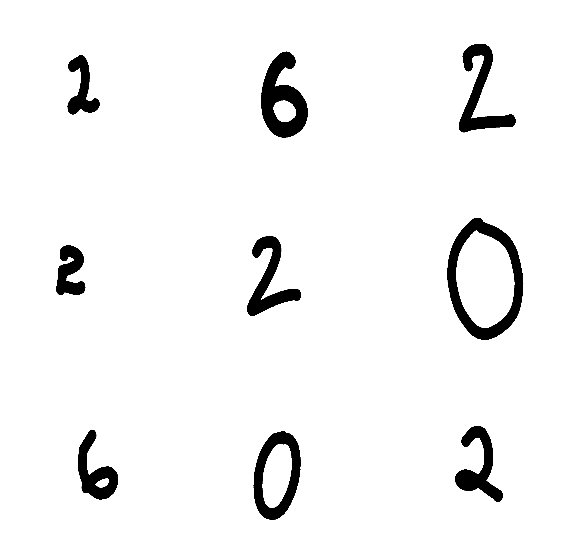

In [4]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(0,9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().reshape(160,160),cmap="gray")
        plt.axis("off")

Adding data augmentation layer

I have added translation, rotation and zoom as augmentation parameters. I have already mentioned reason for not using horizontal and vertical flip in previous task.

In [5]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomTranslation(0.1,0.1),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

Visualising augmented image samples

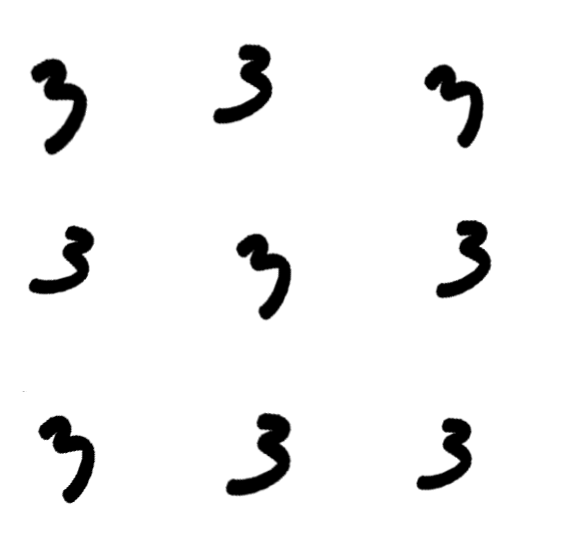

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().reshape(160,160),cmap="gray")
        plt.axis("off")

As one can see, the rotation, translation or zoom isn't too much. The digit 3 still looks like 3. 

**Model 2.1**

Since this is a subset of the set in Part 1, I am using the final Xception-modified model on this one as well. I think I would just need to fine tune some parameters to make it work.

In [20]:
def make_model(input_shape, num_classes):
    
    inputs = keras.Input(shape=input_shape)
    
    # adding data augmentation in model
    x = data_augmentation(inputs)

    # Entry block - same as Xception
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, (3,3), strides=(2,2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Xception blocks - modified
    prev_activation = x  

    for size in [128, 256, 512]:

        # Residual 
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, (3,3), strides=(1,1), padding="same")(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, (3,3), strides=(1,1), padding="same")(x)

        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((3,3), strides=(2,2), padding="same")(x)

        residual = layers.Conv2D(size, (1,1), strides = (2,2), padding="same")(prev_activation)


        # adding back residual
        x = layers.add([x, residual])  
        # setting aside residual for next block
        prev_activation = x 

    # Exit flow - modified 
    x = layers.SeparableConv2D(728, (3,3), strides=(2,2), padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(728, (3,3), strides=(2,2), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

Building and summarizing the model. 

model.summary() helps us to visualise the model - layers and the transformation of input as it goes through the model. It also shows us how many training params we have in the model. 

In [9]:
model1 = make_model(input_shape=(160,160,1), num_classes=10)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 160, 160, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 160, 160, 1)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   320         rescaling[0][0]                  
______________________________________________________________________________________________

Compiling with Adam, lr = 1e-3

I have used categorical_accuracy as the metric as this is a multi class classification probelm. 

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)]
model1.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)

Fitting the model

In [12]:
model1.fit(train_ds, epochs=30, callbacks=callbacks, validation_data=val_ds, verbose =1)

Epoch 1/30
10/10 [==============================] - 7s 403ms/step - loss: 2.3031 - categorical_accuracy: 0.1000 - val_loss: 2.3064 - val_categorical_accuracy: 0.0625
Epoch 2/30
10/10 [==============================] - 6s 314ms/step - loss: 2.2296 - categorical_accuracy: 0.2062 - val_loss: 2.3074 - val_categorical_accuracy: 0.0625
Epoch 3/30
10/10 [==============================] - 6s 312ms/step - loss: 2.2201 - categorical_accuracy: 0.2250 - val_loss: 2.3083 - val_categorical_accuracy: 0.0875
Epoch 4/30
10/10 [==============================] - 6s 316ms/step - loss: 2.1346 - categorical_accuracy: 0.2344 - val_loss: 2.3095 - val_categorical_accuracy: 0.0875
Epoch 5/30
10/10 [==============================] - 6s 316ms/step - loss: 2.0625 - categorical_accuracy: 0.2656 - val_loss: 2.3116 - val_categorical_accuracy: 0.0875
Epoch 6/30
10/10 [==============================] - 6s 314ms/step - loss: 1.9733 - categorical_accuracy: 0.3063 - val_loss: 2.3134 - val_categorical_accuracy: 0.0875
Epoc

The training accuracy is rising rapidly but validation accuracy remains constant. This means the model is overfitting. I think it is learning too fast on the training data.

Let's try reducing learning rate.

Building another instance of the model.

In [47]:
model2 = make_model(input_shape=(160,160,1), num_classes=10)
model2.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 1 0           input_10[0][0]                   
__________________________________________________________________________________________________
rescaling_9 (Rescaling)         (None, 160, 160, 1)  0           sequential[9][0]                 
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 80, 80, 32)   320         rescaling_9[0][0]                
____________________________________________________________________________________________

Compiling with Adam, lr = 1e-4

In [48]:
callbacks = [
    keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)]
model2.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)

Since I have reduced learning rate, I expect it to take more number of epochs.

In [32]:
model2.fit(train_ds, epochs=150, callbacks=callbacks, validation_data=val_ds, verbose =1)

Epoch 1/150
10/10 [==============================] - 8s 342ms/step - loss: 2.3029 - categorical_accuracy: 0.0865 - val_loss: 2.3027 - val_categorical_accuracy: 0.0875
Epoch 2/150
10/10 [==============================] - 6s 324ms/step - loss: 2.3031 - categorical_accuracy: 0.0741 - val_loss: 2.3031 - val_categorical_accuracy: 0.0875
Epoch 3/150
10/10 [==============================] - 6s 320ms/step - loss: 2.3006 - categorical_accuracy: 0.1321 - val_loss: 2.3033 - val_categorical_accuracy: 0.0875
Epoch 4/150
10/10 [==============================] - 6s 319ms/step - loss: 2.2972 - categorical_accuracy: 0.1530 - val_loss: 2.3037 - val_categorical_accuracy: 0.0875
Epoch 5/150
10/10 [==============================] - 6s 315ms/step - loss: 2.2913 - categorical_accuracy: 0.1933 - val_loss: 2.3040 - val_categorical_accuracy: 0.0625
Epoch 6/150
10/10 [==============================] - 6s 318ms/step - loss: 2.2948 - categorical_accuracy: 0.1212 - val_loss: 2.3044 - val_categorical_accuracy: 0.062

xyz good accuracy has been achieved. Pehle hag raha tha but training stabilised in the end. Training ka explain kar - v low pehle, then rises and val acc shoots up, end me stabilises. WHY.

**Training MNIST using pre trained model**

Importing MNIST dataset using Keras API's standard train test split

In [33]:
(X_train, Y_train),(X_test, y_test)= keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Reshaping the train and test datasets to make them compatibel with the model input shape.

Also making sure categorical label vectors are fed to the model because I will be using categorical crossentropy(since it's a multiclass classification problem).

I won't be doing any data preprocessing like rescaling for MNIST because it is not required.

In [34]:
X_train = X_train.reshape([X_train.shape[0],28,28,1])
X_test = X_test.reshape([X_test.shape[0],28,28,1])
Y_train = keras.utils.to_categorical(Y_train)
y_test = keras.utils.to_categorical(y_test)

Building a new instance of the model.

In [46]:
model = make_model(input_shape=(28,28,1), num_classes = 10)

Compiling the model

In [36]:
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)

The pre trained model has been saved as best_model.h5 

I need to load weights from previous model.

References - https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [37]:
model.load_weights("/content/best_model.h5")

In [38]:
model.fit(X_train,Y_train, validation_split=0.1, epochs = 20)

Epoch 1/20
1688/1688 [==============================] - 24s 13ms/step - loss: 0.8521 - categorical_accuracy: 0.7199 - val_loss: 0.1493 - val_categorical_accuracy: 0.9540
Epoch 2/20
1688/1688 [==============================] - 22s 13ms/step - loss: 0.1773 - categorical_accuracy: 0.9446 - val_loss: 0.1220 - val_categorical_accuracy: 0.9613
Epoch 3/20
1688/1688 [==============================] - 21s 13ms/step - loss: 0.1199 - categorical_accuracy: 0.9622 - val_loss: 0.1434 - val_categorical_accuracy: 0.9572
Epoch 4/20
1688/1688 [==============================] - 21s 12ms/step - loss: 0.1022 - categorical_accuracy: 0.9683 - val_loss: 0.0954 - val_categorical_accuracy: 0.9698
Epoch 5/20
1688/1688 [==============================] - 22s 13ms/step - loss: 0.0889 - categorical_accuracy: 0.9726 - val_loss: 0.0793 - val_categorical_accuracy: 0.9762
Epoch 6/20
1688/1688 [==============================] - 21s 13ms/step - loss: 0.0802 - categorical_accuracy: 0.9751 - val_loss: 0.1839 - val_categoric

In [39]:
pred = model.predict(X_test)

In [40]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.0470 - categorical_accuracy: 0.9859


[0.04704929515719414, 0.9858999848365784]

**Training MNIST from scratch**

In [41]:
model_s = make_model(input_shape=(28,28,1), num_classes = 10)
model_s.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 1 0           input_8[0][0]                    
__________________________________________________________________________________________________
rescaling_7 (Rescaling)         (None, 28, 28, 1)    0           sequential[7][0]                 
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 14, 14, 32)   320         rescaling_7[0][0]                
____________________________________________________________________________________________

In [42]:
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]
model_s.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)

In [43]:
model_s.fit(X_train,Y_train, validation_split=0.1, epochs = 50)

Epoch 1/50
1688/1688 [==============================] - 24s 13ms/step - loss: 1.1346 - categorical_accuracy: 0.6084 - val_loss: 0.2278 - val_categorical_accuracy: 0.9303
Epoch 2/50
1688/1688 [==============================] - 21s 13ms/step - loss: 0.1536 - categorical_accuracy: 0.9518 - val_loss: 0.1382 - val_categorical_accuracy: 0.9567
Epoch 3/50
1688/1688 [==============================] - 21s 13ms/step - loss: 0.1090 - categorical_accuracy: 0.9656 - val_loss: 0.0846 - val_categorical_accuracy: 0.9728
Epoch 4/50
1688/1688 [==============================] - 22s 13ms/step - loss: 0.0894 - categorical_accuracy: 0.9716 - val_loss: 0.0652 - val_categorical_accuracy: 0.9802
Epoch 5/50
1688/1688 [==============================] - 22s 13ms/step - loss: 0.0783 - categorical_accuracy: 0.9759 - val_loss: 0.0645 - val_categorical_accuracy: 0.9820
Epoch 6/50
1688/1688 [==============================] - 22s 13ms/step - loss: 0.0679 - categorical_accuracy: 0.9790 - val_loss: 0.1325 - val_categoric

KeyboardInterrupt: ignored

In [45]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.0470 - categorical_accuracy: 0.9859


[0.04704929515719414, 0.9858999848365784]

**Analysis**

The pretrained model starts better off. After the first epoch, its losses(training and val) are lower and accuracies(training and test) are higher. That is precisely the point of pre training networks, so that they can start with better classification weights. 

However, there isn't much difference in the overall training quality using both models in this case. The training is stable in both cases.

Both models converge in around 10-15 epochs.

Both give final accuracy 0.9859, excatly same!

I would like to add that if we would have had a more complex problem, say 100 classes classification or so, the difference between pre trained and non pre trained model would have been visible more clearly.  

The model that I have used is a modified version of Xception, which is a pretty robust model and MNIST is a standard dataset, so it isn't a surprise that it converges fast and trains well on it even when trained from scratch. Maybe with a less robust model also the difference would have been more visible.

# Part3

Note : The dataset for this part is pretty huge, in contrast to Part1 and 2. But I am using the same model from Part1 and data augmentation is integrated into the model. Since there is no disadvantage to it, I am not changing it.

**Data Preprocessing**

In [50]:
#extracting files from zipped folder 
!unzip "mnistTask3.zip"

Streaming output truncated to the last 5000 lines.
 extracting: mnistTask/3/image_021488.jpg  
 extracting: mnistTask/3/image_047540.jpg  
 extracting: mnistTask/3/image_050475.jpg  
 extracting: mnistTask/3/image_024391.jpg  
 extracting: mnistTask/3/image_020193.jpg  
 extracting: mnistTask/3/image_004447.jpg  
 extracting: mnistTask/3/image_051601.jpg  
 extracting: mnistTask/3/image_009900.jpg  
 extracting: mnistTask/3/image_020916.jpg  
 extracting: mnistTask/3/image_025962.jpg  
 extracting: mnistTask/3/image_054889.jpg  
 extracting: mnistTask/3/image_012369.jpg  
 extracting: mnistTask/3/image_025528.jpg  
 extracting: mnistTask/3/image_035609.jpg  
 extracting: mnistTask/3/image_037469.jpg  
 extracting: mnistTask/3/image_057560.jpg  
 extracting: mnistTask/3/image_000119.jpg  
 extracting: mnistTask/3/image_020120.jpg  
 extracting: mnistTask/3/image_044129.jpg  
 extracting: mnistTask/3/image_027779.jpg  
 extracting: mnistTask/3/image_058235.jpg  
 extracting: mnistTask/3/

Making Dataset from image data stored in directory mnistTask3.

In [51]:
image_size = (28,28)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/mnistTask",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=1337,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/mnistTask",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.2,
    shuffle=True,
    subset="validation",
    seed=1337,
)

Found 60000 files belonging to 10 classes.
Using 48000 files for training.
Found 60000 files belonging to 10 classes.
Using 12000 files for validation.


Visualising data from dataset

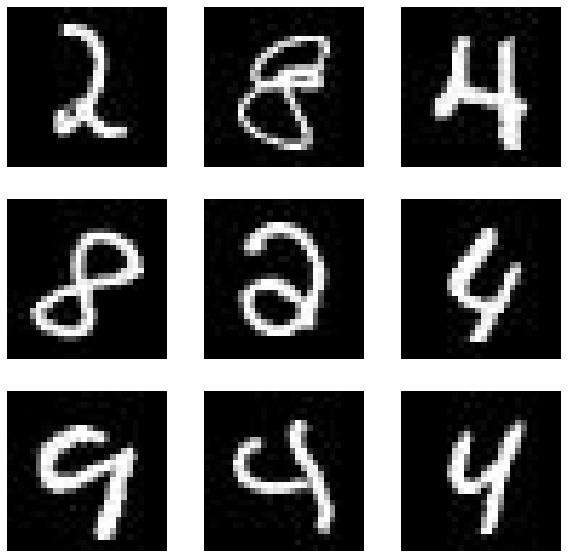

In [52]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(0,9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().reshape(28,28),cmap="gray")
        plt.axis("off")

**Data augmentation**

I have added translation, rotation and zoom as augmentation parameters to the layer. 

In [53]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomTranslation(0.1,0.1),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

**Training from scratch** 

In [56]:
model1 = make_model((28,28,1),10)
model1.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 28, 28, 1)    0           input_11[0][0]                   
__________________________________________________________________________________________________
rescaling_10 (Rescaling)        (None, 28, 28, 1)    0           sequential_1[0][0]               
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 14, 14, 32)   320         rescaling_10[0][0]               
___________________________________________________________________________________________

In [57]:
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]
model1.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)

In [58]:
model1.fit(train_ds,  epochs = 50, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
1500/1500 [==============================] - 41s 26ms/step - loss: 2.3009 - categorical_accuracy: 0.1077 - val_loss: 2.2906 - val_categorical_accuracy: 0.1085
Epoch 2/50
1500/1500 [==============================] - 47s 31ms/step - loss: 2.2891 - categorical_accuracy: 0.1085 - val_loss: 2.2686 - val_categorical_accuracy: 0.1085
Epoch 3/50
1500/1500 [==============================] - 41s 27ms/step - loss: 2.2726 - categorical_accuracy: 0.1109 - val_loss: 2.2509 - val_categorical_accuracy: 0.1102
Epoch 4/50
1500/1500 [==============================] - 40s 27ms/step - loss: 2.2590 - categorical_accuracy: 0.1128 - val_loss: 2.2407 - val_categorical_accuracy: 0.1091
Epoch 5/50
1500/1500 [==============================] - 41s 27ms/step - loss: 2.2509 - categorical_accuracy: 0.1125 - val_loss: 2.2309 - val_categorical_accuracy: 0.1093
Epoch 6/50
1500/1500 [==============================] - 40s 27ms/step - loss: 2.2434 - categorical_accuracy: 0.1137 - val_loss: 2.2298 - val_categoric

KeyboardInterrupt: ignored

I stopped the training manually because both training and test accuracy is not increasing. They are stuck at the same value. So clearly, the traning isn't going anywhere.

Testing on MNIST dataset

In [60]:
model1.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 6.0850 - categorical_accuracy: 3.0000e-04


[6.084980487823486, 0.0003000000142492354]

**Training using pre trained model**

Building and summarising the model

In [61]:
model2 = make_model((28,28,1),10)
model2.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 28, 28, 1)    0           input_12[0][0]                   
__________________________________________________________________________________________________
rescaling_11 (Rescaling)        (None, 28, 28, 1)    0           sequential_1[1][0]               
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 14, 14, 32)   320         rescaling_11[0][0]               
___________________________________________________________________________________________

Compiling the model

In [62]:
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]
model2.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)

Loading pre trained model weights



In [63]:
model2.load_weights("/content/best_model.h5")

Fitting the model

In [64]:
model2.fit(train_ds,  epochs = 30, callbacks=callbacks, validation_data=val_ds)

Epoch 1/30
1500/1500 [==============================] - 42s 26ms/step - loss: 2.3192 - categorical_accuracy: 0.1091 - val_loss: 2.2909 - val_categorical_accuracy: 0.1096
Epoch 2/30
1500/1500 [==============================] - 40s 26ms/step - loss: 2.2842 - categorical_accuracy: 0.1113 - val_loss: 2.2767 - val_categorical_accuracy: 0.1055
Epoch 3/30
1500/1500 [==============================] - 39s 26ms/step - loss: 2.2733 - categorical_accuracy: 0.1117 - val_loss: 2.2536 - val_categorical_accuracy: 0.1117
Epoch 4/30
1500/1500 [==============================] - 38s 26ms/step - loss: 2.2642 - categorical_accuracy: 0.1112 - val_loss: 2.2565 - val_categorical_accuracy: 0.1082
Epoch 5/30
1500/1500 [==============================] - 38s 25ms/step - loss: 2.2572 - categorical_accuracy: 0.1096 - val_loss: 2.2383 - val_categorical_accuracy: 0.1133
Epoch 6/30
1500/1500 [==============================] - 39s 26ms/step - loss: 2.2496 - categorical_accuracy: 0.1128 - val_loss: 2.2326 - val_categoric

Test accuracy on MNIST dataset

In [66]:
model2.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 5.3526 - categorical_accuracy: 0.0010


[5.352646827697754, 0.0010000000474974513]

**Analysis**

**Comparison between the models**

Test accuracy on MNIST : Both have very low accuracy, very close to 0.The pre trained model is just a notch better - by a factor of 10. But that doesn't really matter since the accuracy values are too small.

Training : Training is pretty similar. The pre trained network showed no advantage over the non pre trained network. Losses and accuracies were very similar.

Convergence : There was no convergence in any of the two models.


**Qualitative Analysis**

The pretrained network performs as bad as network trained from scratch because the dataset is shuffled. In the folder labelled 0, there are images of all 9 digits. Similarly, in other folders as well. So, basically, the data that we are feeding into the network is itself misclassified. Therefore no matter how good the network, pre trained or not. It just can't learn the right thing with wrong information. It cannot learn to segregate classes when the input itself has randomly shuffled images in each class. 

The model hasn't really learnt anything so the situation is similar shooting in the dark - just making a guess

Evidently, it hovers around probabilistically expected accuracy for making a guess in a 10 class classification - 1/10 i.e. 0.1